In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd
from pydmd import DMDc, DMD
from pydmd.plotter import plot_eigs, plot_summary, plot_eigs, plot_modes_2D
import os
import re
from flowtorch.data import FOAMDataloader, mask_box
import torch as pt
from pydmd.dmd_modes_tuner import ModesSelectors, select_modes


Refer to the installation instructions at https://github.com/FlowModelingControl/flowtorch
If you are not using the TecplotDataloader, ignore this warning.


In [3]:
# Rank v/s error analysis for unforced case
folder_path = "/home/tanuj/SHK/Fluid_Mechanics/DMD/temp/unforced_case/simulation"
loader = FOAMDataloader(folder_path, distributed=True)
times = loader.write_times
vertices = loader.vertices
x, y = np.array(vertices[:, 0]), np.array(vertices[:, 1])
print(x.shape, y.shape)

p_unforced = np.array(loader.load_snapshot("p", times[1:]))[:,399:]
print(p_unforced.shape)


(21250,) (21250,)
(21250, 401)


In [4]:
#Splitting test-train data
train_test_ratio = 0.75
index = round(train_test_ratio*p_unforced.shape[1])
train_data = p_unforced[:,:index]
test_data = p_unforced[:,index:]
print(train_data.shape)
print(test_data.shape)

(21250, 301)
(21250, 100)


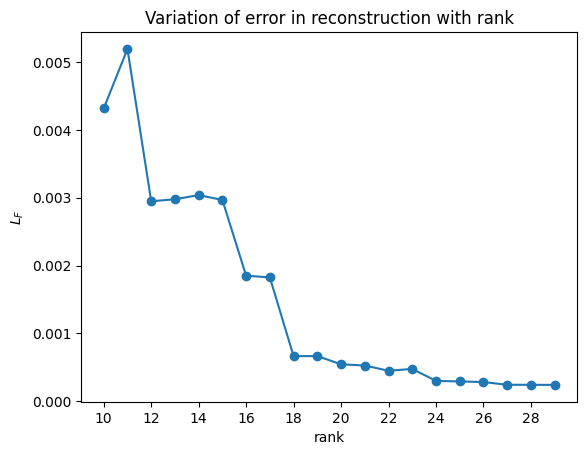

In [9]:
ranks = list(range(10, 30))
err_reconstruction = []
for r in ranks:
    dmd_unforced = DMD(svd_rank = r)
    dmd_unforced.fit(train_data)
    reconstructed_data = dmd_unforced.reconstructed_data
    error = np.linalg.norm(train_data-reconstructed_data)/np.linalg.norm(train_data)
    err_reconstruction.append(error)

plt.xlabel("rank")
plt.ylabel(r"$L_{F}$")
plt.xticks(np.arange(0, 30, step = 2))
plt.title("Variation of error in reconstruction with rank")
plt.plot(ranks, err_reconstruction, marker = 'o')
plt.show()

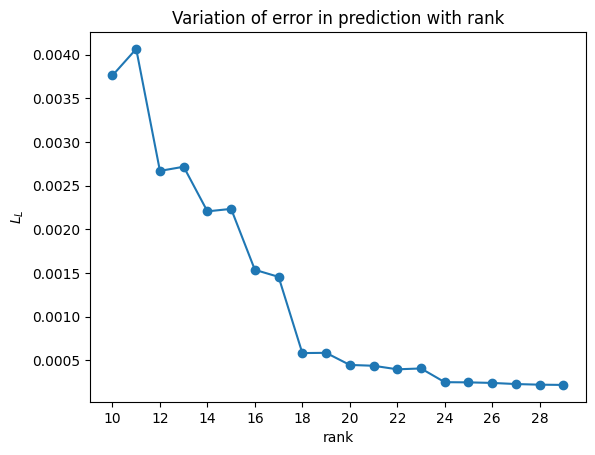

In [13]:
# Variation of Error in predicting future flow for different ranks

ranks = list(range(10, 30))
err_prediction = []
for r in ranks:
    dmd_unforced = DMD(svd_rank = r)
    dmd_unforced.fit(train_data)
    x_curr = train_data[:,-1]
    x_curr = x_curr.reshape(len(x_curr),1)
    predicted_flow = np.empty((len(x_curr), 0))
    for i in range(test_data.shape[1]):
        x_curr = dmd_unforced.predict(x_curr)
        predicted_flow = np.hstack((predicted_flow,x_curr))

    error = np.linalg.norm(test_data-predicted_flow)/np.linalg.norm(test_data)
    err_prediction.append(error)

plt.xlabel("rank")
plt.ylabel(r"$L_{L}$")
plt.xticks(np.arange(0, 30, step = 2))
plt.title("Variation of error in prediction with rank")
plt.plot(ranks, err_prediction, marker = 'o')
plt.show()

In [12]:
# Rank v/s error analysis for DMD of Forced case with forcing frequency ratio of 1
folder_path = "/home/tanuj/SHK/Fluid_Mechanics/DMD/optDMDc/param_simulation/run/A0.5f3.0"
loader = FOAMDataloader(folder_path, distributed=True)
times = loader.write_times
vertices = loader.vertices
x, y = np.array(vertices[:, 0]), np.array(vertices[:, 1])
print(x.shape, y.shape)

p_forced = np.array(loader.load_snapshot("p", times[1:]))[:,399:]
print(p_forced.shape)
times_num = np.array(list(map(float, times)))
times_num = times_num[400:]


(21250,) (21250,)
(21250, 401)


In [6]:
#Splitting test-train data
train_test_ratio = 0.75
index = round(train_test_ratio*p_forced.shape[1])
train_data = p_forced[:,:index]
test_data = p_forced[:,index:]
print(train_data.shape)
print(test_data.shape)

(21250, 301)
(21250, 100)


/home/tanuj/.local/lib/python3.10/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 858215744.0. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


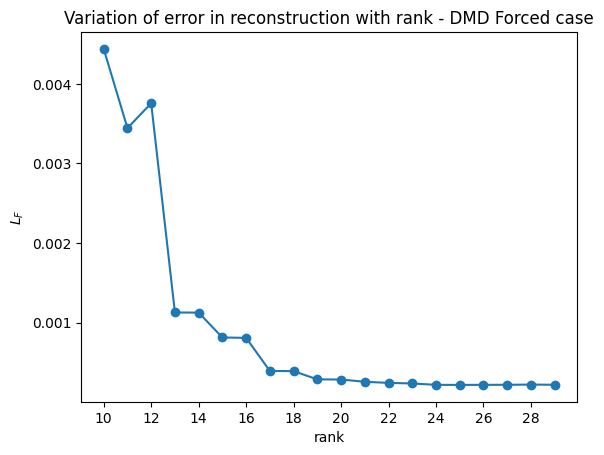

In [7]:
ranks = list(range(10, 30))
err_reconstruction = []
for r in ranks:
    dmd_forced = DMD(svd_rank = r)
    dmd_forced.fit(train_data)
    reconstructed_data = dmd_forced.reconstructed_data
    error = np.linalg.norm(train_data-reconstructed_data)/np.linalg.norm(train_data)
    err_reconstruction.append(error)

plt.xlabel("rank")
plt.ylabel(r"$L_{F}$")
plt.xticks(np.arange(0, 30, step = 2))
plt.title("Variation of error in reconstruction with rank - DMD Forced case")
plt.plot(ranks, err_reconstruction, marker = 'o')
plt.show()

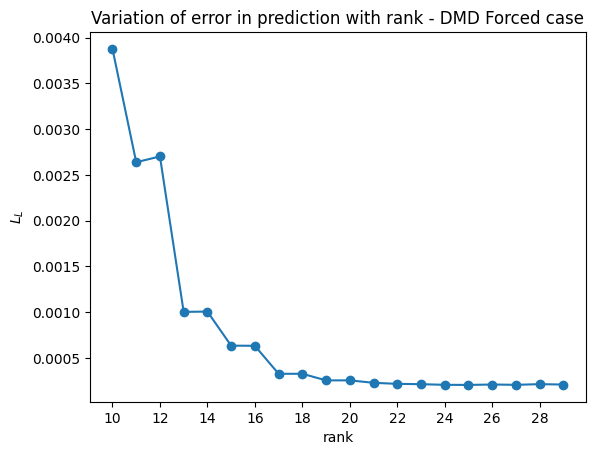

In [8]:
# Variation of Error in predicting future flow for different ranks

ranks = list(range(10, 30))
err_prediction = []
for r in ranks:
    dmd_forced = DMD(svd_rank = r)
    dmd_forced.fit(train_data)
    x_curr = train_data[:,-1]
    x_curr = x_curr.reshape(len(x_curr),1)
    predicted_flow = np.empty((len(x_curr), 0))
    for i in range(test_data.shape[1]):
        x_curr = dmd_forced.predict(x_curr)
        predicted_flow = np.hstack((predicted_flow,x_curr))

    error = np.linalg.norm(test_data-predicted_flow)/np.linalg.norm(test_data)
    err_prediction.append(error)

plt.xlabel("rank")
plt.ylabel(r"$L_{L}$")
plt.xticks(np.arange(0, 30, step = 2))
plt.title("Variation of error in prediction with rank - DMD Forced case")
plt.plot(ranks, err_prediction, marker = 'o')
plt.show()

In [13]:
# Rank v/s error analysis for DMD with control of Forced case with forcing frequency ratio of 1
# The train and test data remains the same
A, f = 0.5, 3.0
u = np.atleast_2d(A*np.sin(2*np.pi*f*times_num[:-1]))
train_u = u[:,:index-1]
test_u = u[:,index-1:]



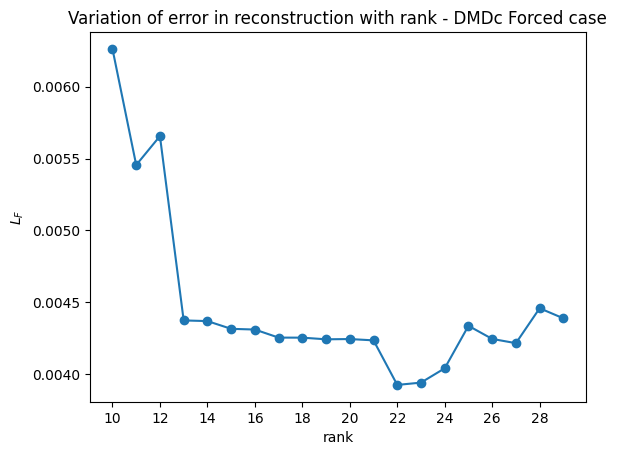

In [23]:

ranks = list(range(10, 30))
err_reconstruction = []
for r in ranks:
    dmdc_forced = DMDc(svd_rank = r)
    dmdc_forced.fit(train_data, train_u)
    reconstructed_data = dmdc_forced.reconstructed_data().real
    error = np.linalg.norm(train_data-reconstructed_data)/np.linalg.norm(train_data)
    err_reconstruction.append(error)

plt.xlabel("rank")
plt.ylabel(r"$L_{F}$")
plt.xticks(np.arange(0, 30, step = 2))
plt.title("Variation of error in reconstruction with rank - DMDc Forced case")
plt.plot(ranks, err_reconstruction, marker = 'o')
plt.show()

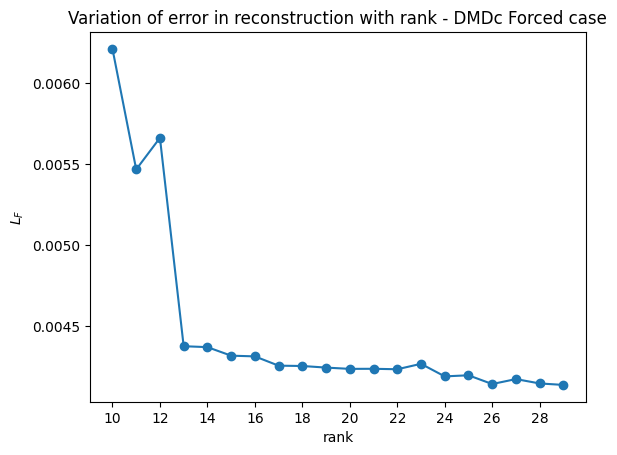

In [22]:

ranks = list(range(10, 30))
err_reconstruction = []
train_u_new = u[:,:index]
for r in ranks:
    dmdc_forced = DMDc(svd_rank = r)
    dmdc_forced.fit(train_data, train_u)
    A_tilde = dmdc_forced._Atilde._Atilde
    #print(A_tilde.shape)
    B_tilde = dmdc_forced.basis.T.dot(dmdc_forced.B)
    #print(B_tilde.shape)
    x_curr = dmdc_forced.basis.T.dot(train_data[:,0])
    x_curr = x_curr.reshape(len(x_curr),1)
    predicted_flow_tilde = np.empty((len(x_curr), 0))
    predicted_flow_tilde = np.hstack((predicted_flow_tilde,x_curr))    
    for i in range(train_data.shape[1]-1):
        x_curr = A_tilde.dot(x_curr) + B_tilde.dot(train_u[0,i])
        predicted_flow_tilde = np.hstack((predicted_flow_tilde,x_curr))
    reconstructed_data = dmdc_forced.basis.dot(predicted_flow_tilde)

    error = np.linalg.norm(train_data-reconstructed_data)/np.linalg.norm(train_data)
    err_reconstruction.append(error)

plt.xlabel("rank")
plt.ylabel(r"$L_{F}$")
plt.xticks(np.arange(0, 30, step = 2))
plt.title("Variation of error in reconstruction with rank - DMDc Forced case")
plt.plot(ranks, err_reconstruction, marker = 'o')
plt.show()

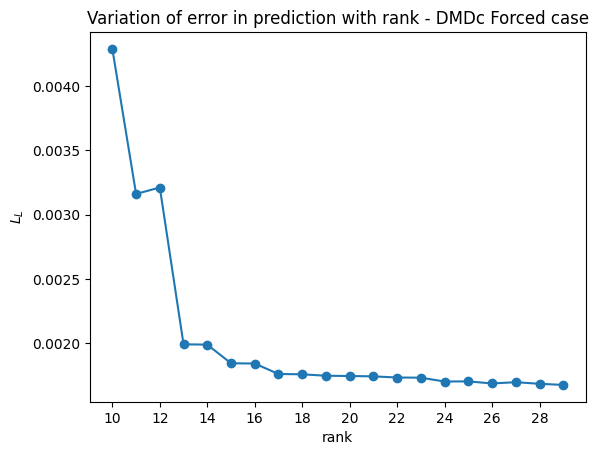

In [16]:
# Variation of Error in predicting future flow for different ranks

ranks = list(range(10, 30))
err_prediction = []
for r in ranks:
    dmdc_forced = DMDc(svd_rank = r)
    dmdc_forced.fit(train_data, train_u)
    A_tilde = dmdc_forced._Atilde._Atilde
    #print(A_tilde.shape)
    B_tilde = dmdc_forced.basis.T.dot(dmdc_forced.B)
    #print(B_tilde.shape)
    x_curr = dmdc_forced.basis.T.dot(train_data[:,-1])
    x_curr = x_curr.reshape(len(x_curr),1)
    predicted_flow_tilde = np.empty((len(x_curr), 0))
    for i in range(test_data.shape[1]):
        x_curr = A_tilde.dot(x_curr) + B_tilde.dot(test_u[0,i])
        predicted_flow_tilde = np.hstack((predicted_flow_tilde,x_curr))
    predicted_flow = dmdc_forced.basis.dot(predicted_flow_tilde)
    error = np.linalg.norm(test_data-predicted_flow)/np.linalg.norm(test_data)
    err_prediction.append(error)

plt.xlabel("rank")
plt.ylabel(r"$L_{L}$")
plt.xticks(np.arange(0, 30, step = 2))
plt.title("Variation of error in prediction with rank - DMDc Forced case")
plt.plot(ranks, err_prediction, marker = 'o')
plt.show()

## Selected Ranks from analysis
1. DMD for unforced case - 24
2. DMD for forced case - 24
3. DMDc for forced case - 26

In [3]:
# Evaluating dynamics of each case
# Case 1 - DMD for unforced
folder_path = "/home/tanuj/SHK/Fluid_Mechanics/DMD/temp/unforced_case/simulation"
loader = FOAMDataloader(folder_path, distributed=True)
times = loader.write_times
vertices = loader.vertices
x, y = np.array(vertices[:, 0]), np.array(vertices[:, 1])
print(x.shape, y.shape)

p_unforced = np.array(loader.load_snapshot("p", times[1:]))[:,399:]
print(p_unforced.shape)

(21250,) (21250,)
(21250, 401)


/home/tanuj/.local/lib/python3.10/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 1000770.5. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/home/tanuj/.local/lib/python3.10/site-packages/pydmd/plotter.py:195: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend(


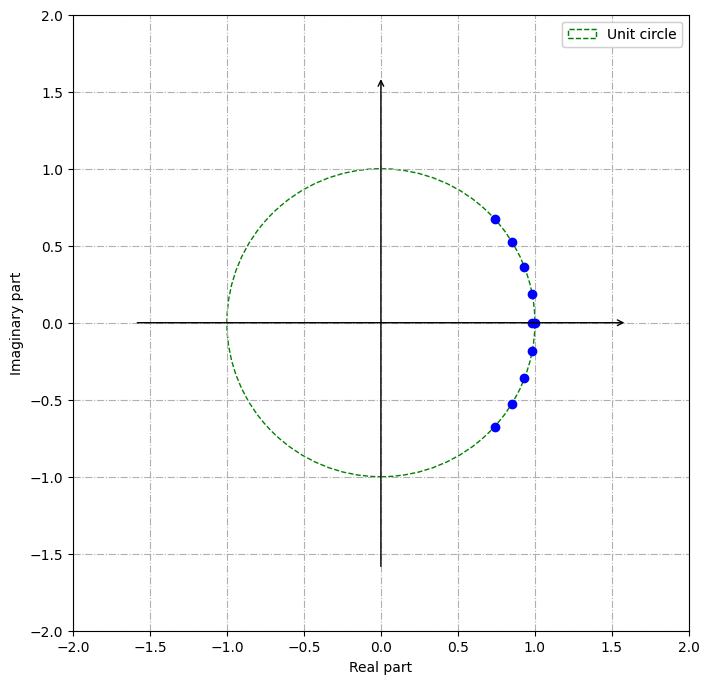

(21250, 10)

In [4]:
dmd_unforced = DMD(svd_rank = 24)
dmd_unforced.fit(p_unforced)
selected_modes = select_modes(dmd_unforced, ModesSelectors.integral_contribution(10))
plot_eigs(selected_modes)
selected_modes.modes.shape

[15  8  9 10 11 20 21 16 17 14]


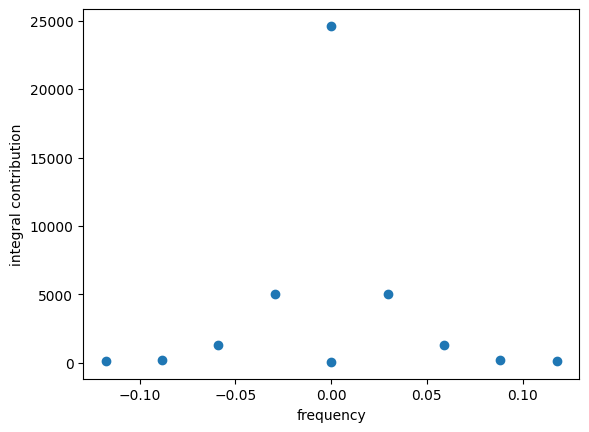

In [21]:
#Calculating Integral contribution
dmd_unforced = DMD(svd_rank = 24)
dmd_unforced.fit(p_unforced)

dynamics = dmd_unforced.dynamics
modes = dmd_unforced.modes
n_of_modes = modes.shape[1]
integral_contributions = [ModesSelectors._compute_integral_contribution(*tp) for tp in zip(modes.T, dynamics)]
frequency = dmd_unforced.frequency
#print(frequency)
n = 10
indexes_first_n = np.array(integral_contributions).argsort()[-n:]
print(indexes_first_n)
plt.scatter(frequency[indexes_first_n], np.array(integral_contributions)[indexes_first_n])
plt.xlabel("frequency")
plt.ylabel("integral contribution")
plt.show()

(21250, 10)


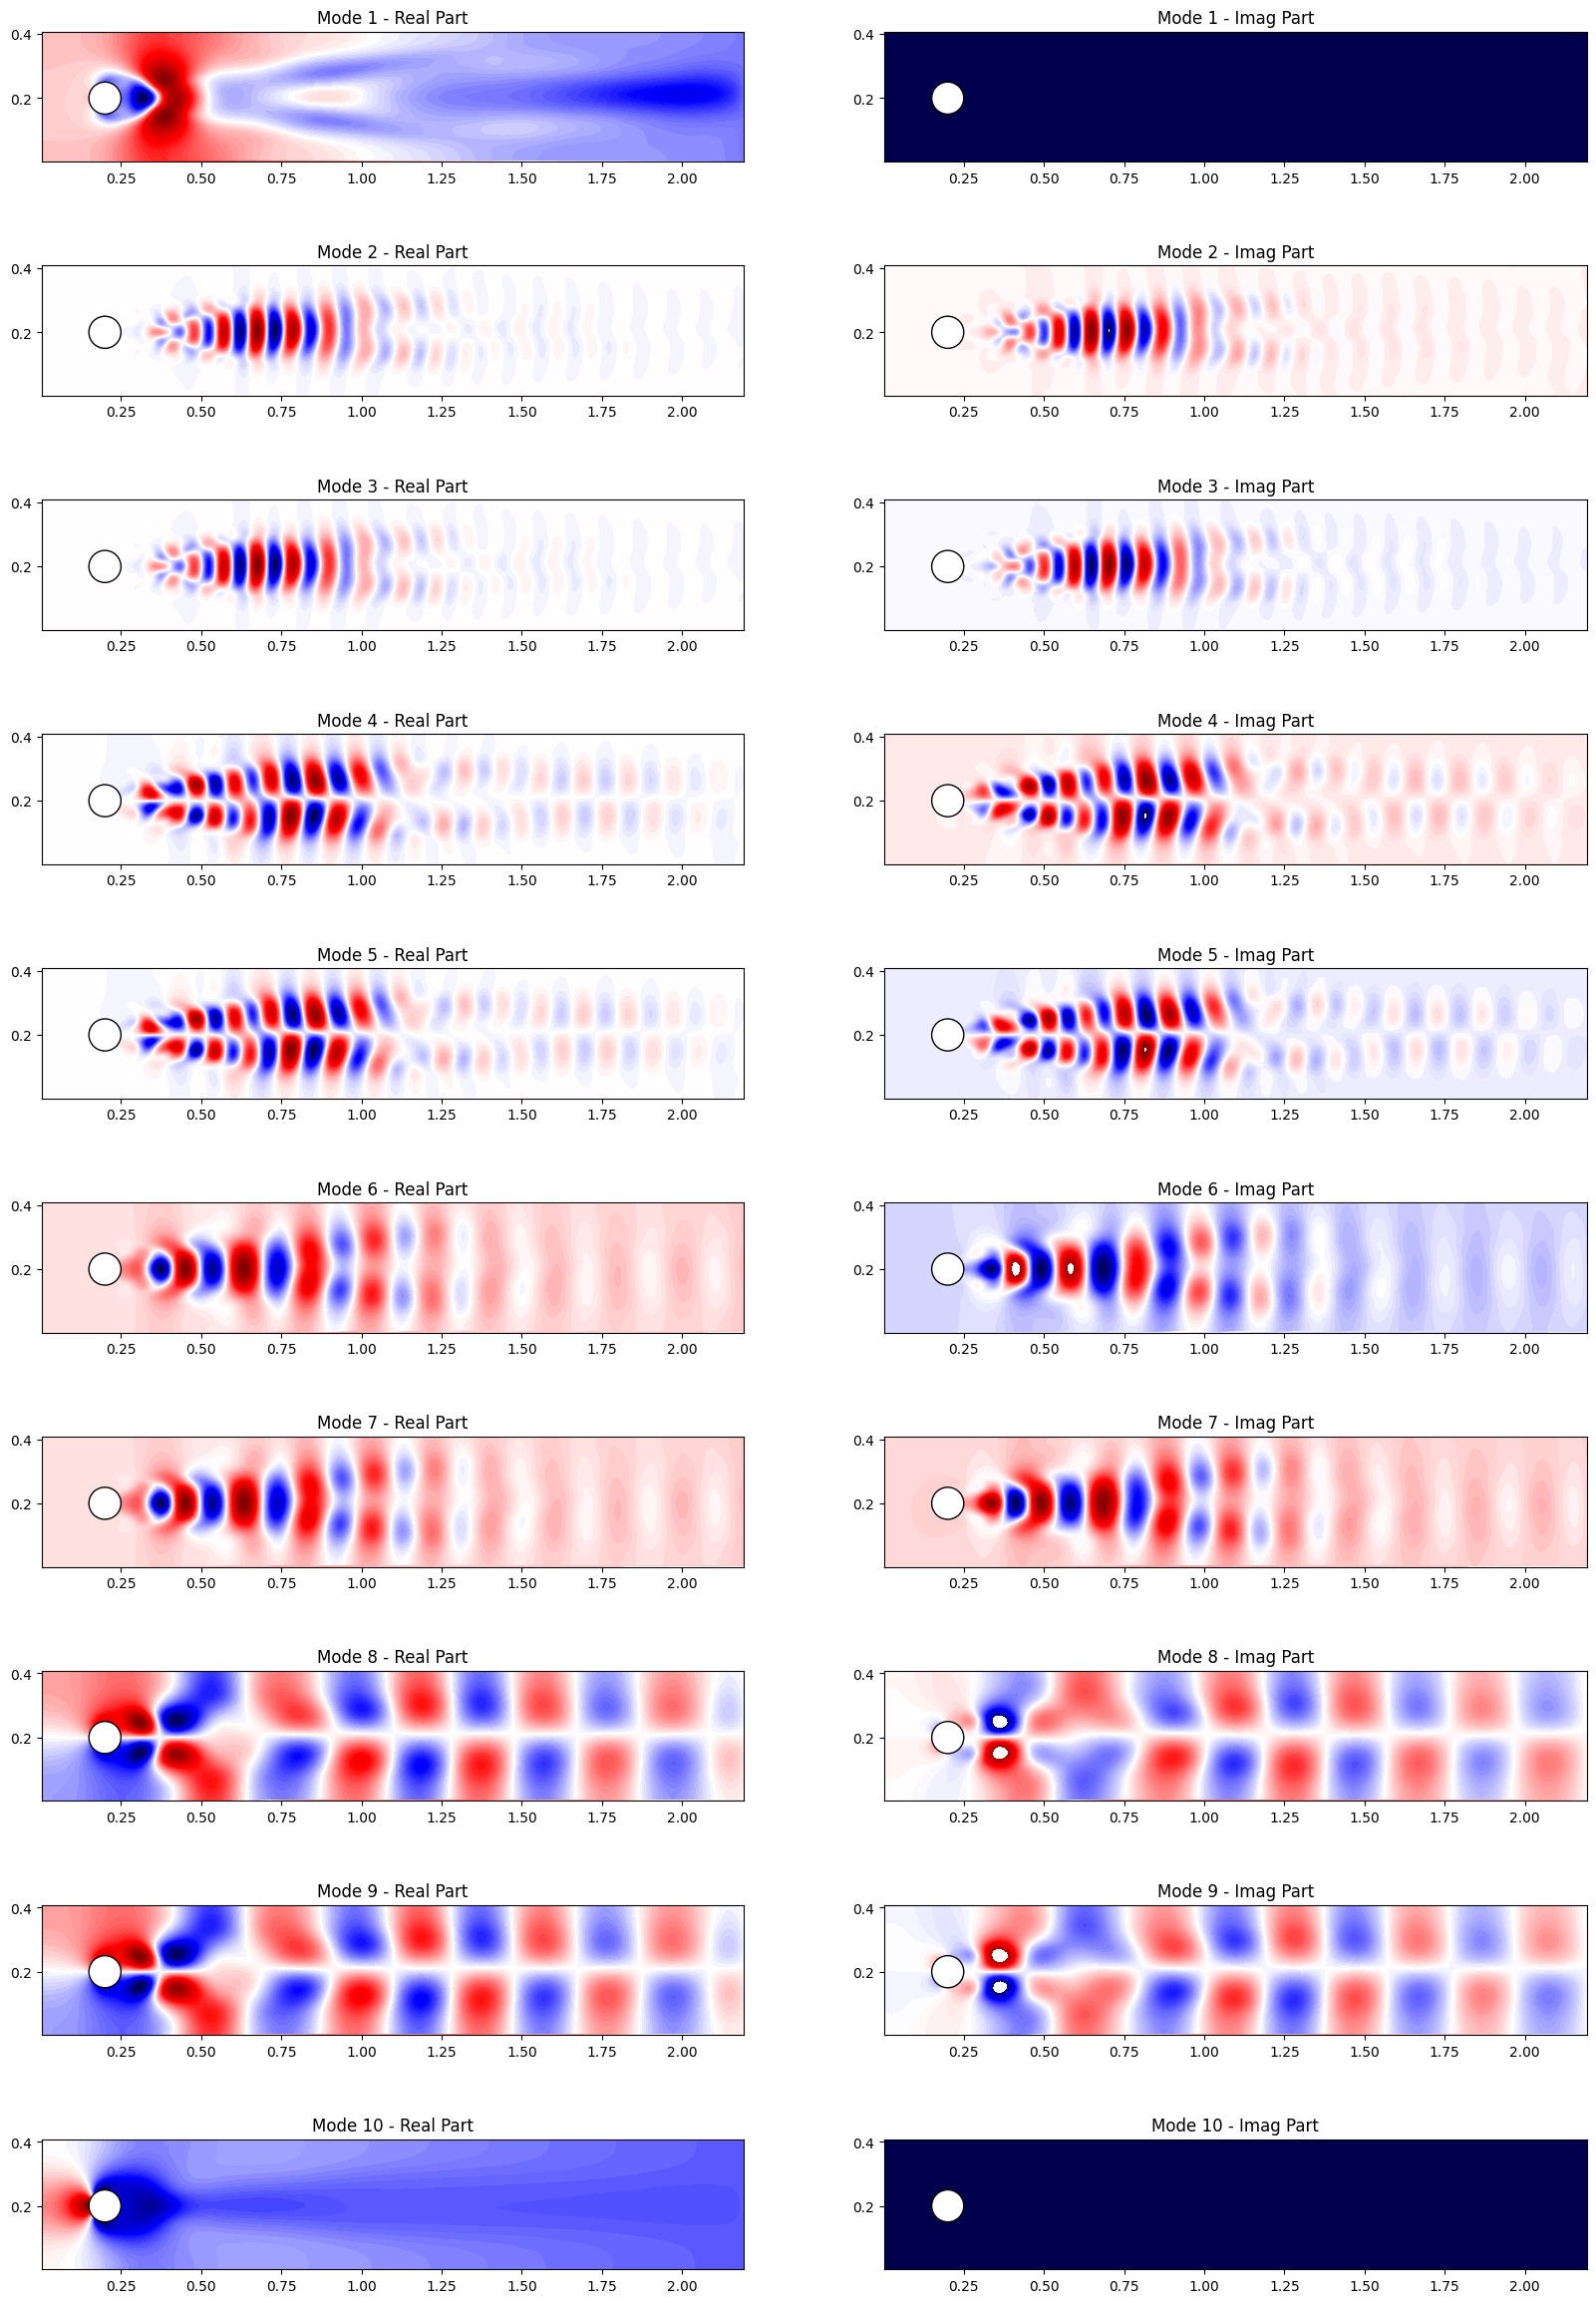

In [25]:
# Plot modes

no_modes = 10
fig, ax = plt.subplots(figsize = (20,3.0*no_modes), nrows = no_modes, ncols = 2)
selected_modes = modes[:,indexes_first_n]
print(selected_modes.shape)
for i in range(no_modes):
    mode = selected_modes[:, i]
    ax[i,0].tricontourf(x, y, mode.real, levels = np.linspace(mode.real.min(), mode.real.max(), 100), vmin=mode.real.min(), vmax=mode.real.max(), cmap="seismic")
    ax[i,0].add_patch(plt.Circle((0.2, 0.2), 0.05, color='black', lw = 1, fc='w'))
    ax[i,0].set_aspect("equal")
    ax[i,0].set_title("Mode {} - Real Part".format(i+1))
    
    ax[i,1].tricontourf(x, y, mode.imag, levels = np.linspace(mode.real.min(), mode.real.max(), 100), vmin=mode.imag.min(), vmax=mode.imag.max(), cmap="seismic")
    ax[i,1].add_patch(plt.Circle((0.2, 0.2), 0.05, color='black', lw = 1, fc='w'))
    ax[i,1].set_aspect("equal")
    ax[i,1].set_title("Mode {} - Imag Part".format(i+1))


In [29]:
# Case 2 - DMD for forced
folder_path = "/home/tanuj/SHK/Fluid_Mechanics/DMD/optDMDc/param_simulation/run/A0.5f3.0"
loader = FOAMDataloader(folder_path, distributed=True)
times = loader.write_times
vertices = loader.vertices
x, y = np.array(vertices[:, 0]), np.array(vertices[:, 1])
print(x.shape, y.shape)

p_forced = np.array(loader.load_snapshot("p", times[1:]))[:,399:]
print(p_forced.shape)
times_num = np.array(list(map(float, times)))
times_num = times_num[400:]


(21250,) (21250,)
(21250, 401)


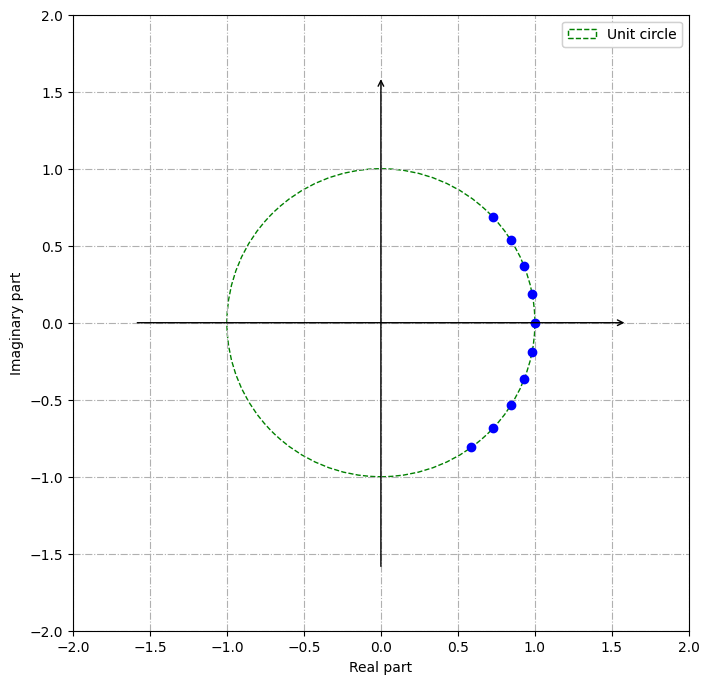

In [30]:
dmd_forced = DMD(svd_rank = 24)
dmd_forced.fit(p_forced)
selected_modes = select_modes(dmd_forced, ModesSelectors.integral_contribution(10))
plot_eigs(selected_modes)

[19 12 11  9 10  5  4  7  6  3]


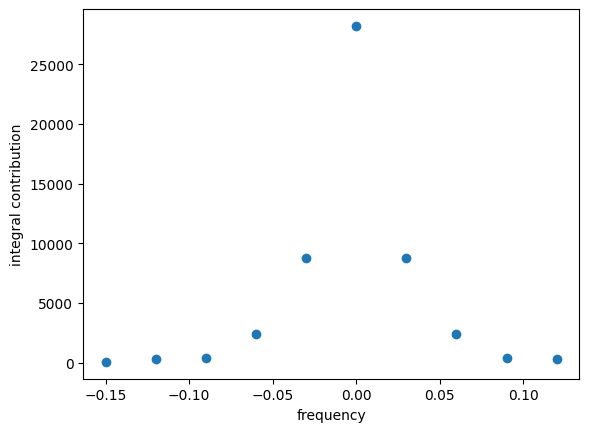

In [31]:
#Calculating Integral contribution
dmd_forced = DMD(svd_rank = 24)
dmd_forced.fit(p_forced)

dynamics = dmd_forced.dynamics
modes = dmd_forced.modes
n_of_modes = modes.shape[1]
integral_contributions = [ModesSelectors._compute_integral_contribution(*tp) for tp in zip(modes.T, dynamics)]
frequency = dmd_forced.frequency
#print(frequency)
n = 10
indexes_first_n = np.array(integral_contributions).argsort()[-n:]
print(indexes_first_n)
plt.scatter(frequency[indexes_first_n], np.array(integral_contributions)[indexes_first_n])
plt.xlabel("frequency")
plt.ylabel("integral contribution")
plt.show()

(21250, 10)


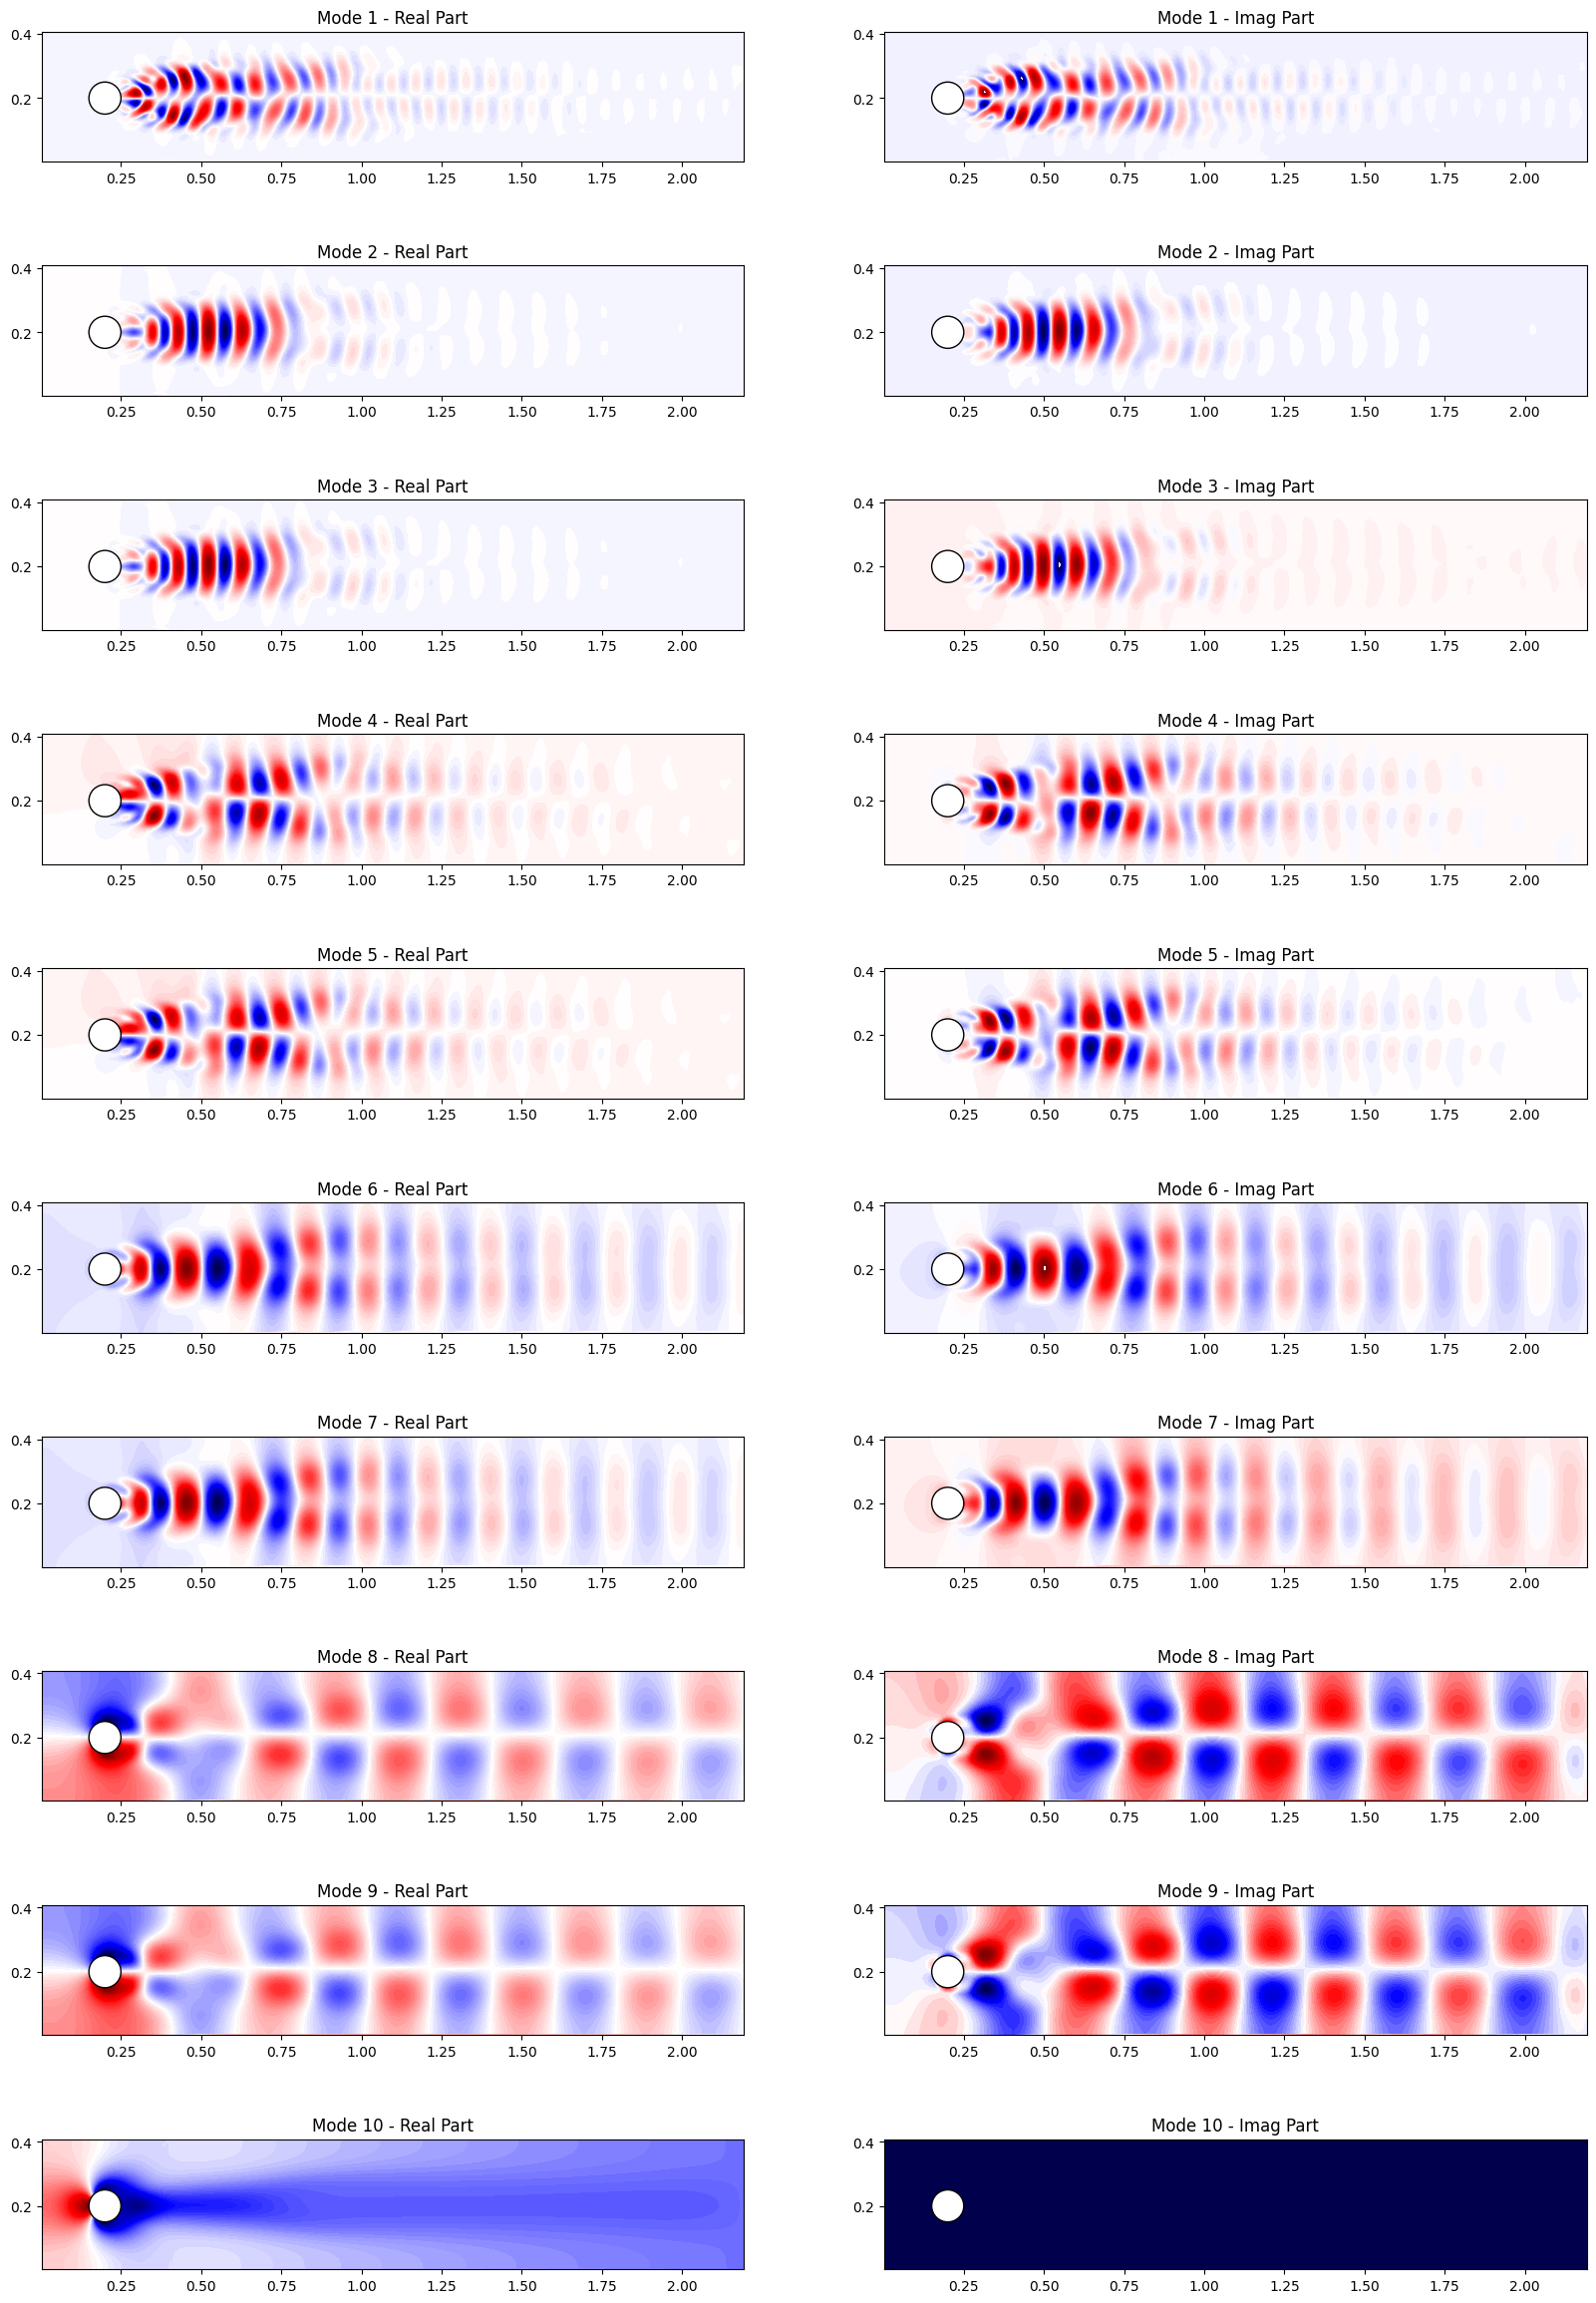

In [32]:
# Plot modes


no_modes = 10
fig, ax = plt.subplots(figsize = (20,3.0*no_modes), nrows = no_modes, ncols = 2)
selected_modes = modes[:,indexes_first_n]
print(selected_modes.shape)
for i in range(no_modes):
    mode = selected_modes[:, i]
    ax[i,0].tricontourf(x, y, mode.real, levels = np.linspace(mode.real.min(), mode.real.max(), 100), vmin=mode.real.min(), vmax=mode.real.max(), cmap="seismic")
    ax[i,0].add_patch(plt.Circle((0.2, 0.2), 0.05, color='black', lw = 1, fc='w'))
    ax[i,0].set_aspect("equal")
    ax[i,0].set_title("Mode {} - Real Part".format(i+1))
    
    ax[i,1].tricontourf(x, y, mode.imag, levels = np.linspace(mode.real.min(), mode.real.max(), 100), vmin=mode.imag.min(), vmax=mode.imag.max(), cmap="seismic")
    ax[i,1].add_patch(plt.Circle((0.2, 0.2), 0.05, color='black', lw = 1, fc='w'))
    ax[i,1].set_aspect("equal")
    ax[i,1].set_title("Mode {} - Imag Part".format(i+1))


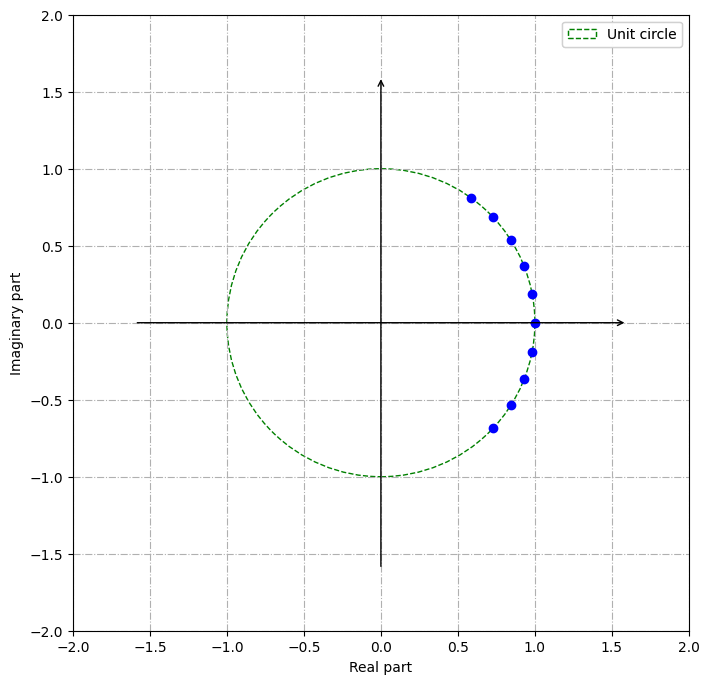

In [36]:
# Case 3 - DMDc for forced
# Using the same data
A, f = 0.5, 3.0
u = np.atleast_2d(A*np.sin(2*np.pi*f*times_num[:-1]))
dmdc_forced = DMDc(svd_rank = 26)
dmdc_forced.fit(p_forced, u)
selected_modes = select_modes(dmdc_forced, ModesSelectors.integral_contribution(10))
plot_eigs(selected_modes)

[20 17 16 15 14  9 10 12 11  8]


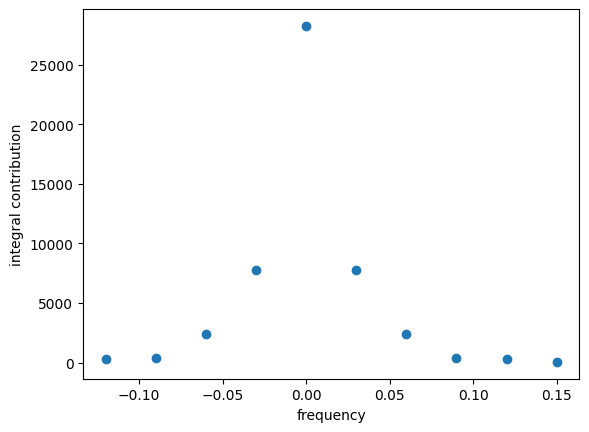

In [38]:
#Calculating Integral contribution
dmdc_forced = DMDc(svd_rank = 24)
A, f = 0.5, 3.0
u = np.atleast_2d(A*np.sin(2*np.pi*f*times_num[:-1]))

dmdc_forced.fit(p_forced, u)

dynamics = dmdc_forced.dynamics
modes = dmdc_forced.modes
n_of_modes = modes.shape[1]
integral_contributions = [ModesSelectors._compute_integral_contribution(*tp) for tp in zip(modes.T, dynamics)]
frequency = dmdc_forced.frequency
#print(frequency)
n = 10
indexes_first_n = np.array(integral_contributions).argsort()[-n:]
print(indexes_first_n)
plt.scatter(frequency[indexes_first_n], np.array(integral_contributions)[indexes_first_n])
plt.xlabel("frequency")
plt.ylabel("integral contribution")
plt.show()

(21250, 10)


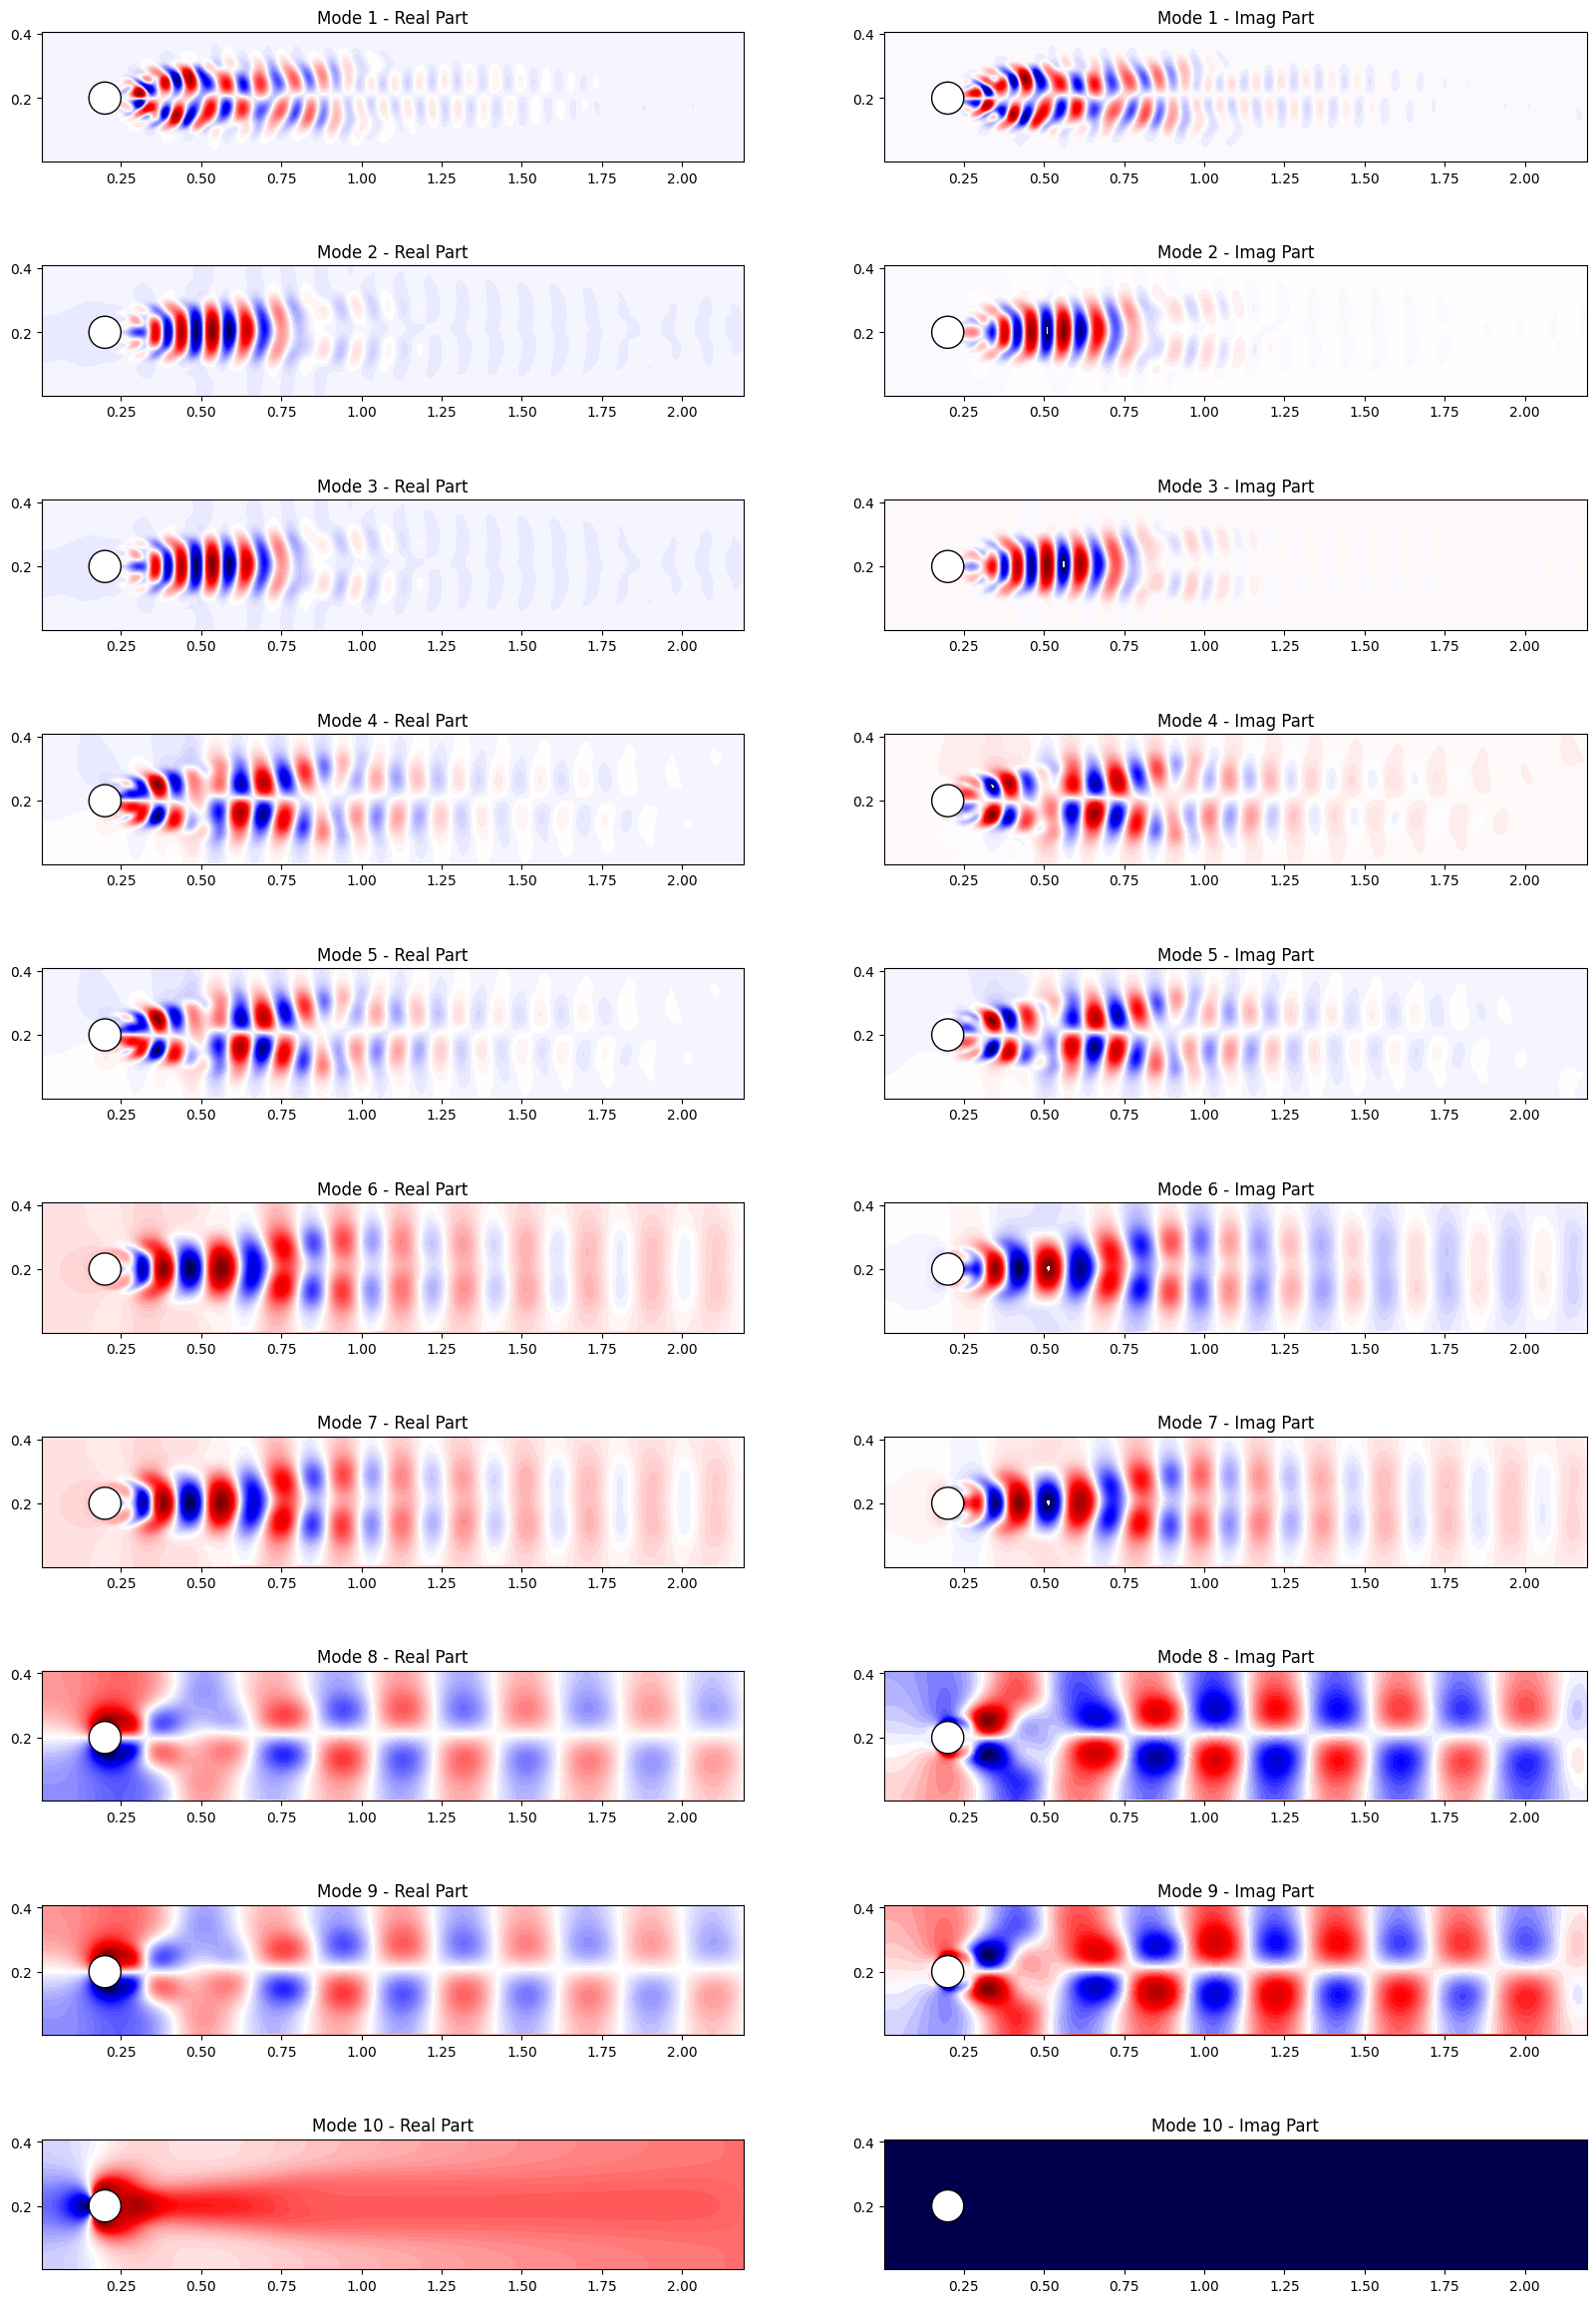

In [39]:
# Plot modes



no_modes = 10
fig, ax = plt.subplots(figsize = (20,3.0*no_modes), nrows = no_modes, ncols = 2)
selected_modes = modes[:,indexes_first_n]
print(selected_modes.shape)
for i in range(no_modes):
    mode = selected_modes[:, i]
    ax[i,0].tricontourf(x, y, mode.real, levels = np.linspace(mode.real.min(), mode.real.max(), 100), vmin=mode.real.min(), vmax=mode.real.max(), cmap="seismic")
    ax[i,0].add_patch(plt.Circle((0.2, 0.2), 0.05, color='black', lw = 1, fc='w'))
    ax[i,0].set_aspect("equal")
    ax[i,0].set_title("Mode {} - Real Part".format(i+1))
    
    ax[i,1].tricontourf(x, y, mode.imag, levels = np.linspace(mode.real.min(), mode.real.max(), 100), vmin=mode.imag.min(), vmax=mode.imag.max(), cmap="seismic")
    ax[i,1].add_patch(plt.Circle((0.2, 0.2), 0.05, color='black', lw = 1, fc='w'))
    ax[i,1].set_aspect("equal")
    ax[i,1].set_title("Mode {} - Imag Part".format(i+1))

